In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.lines import Line2D
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE, SAMPLE, PAIRED_SAMPLES, get_experiment_artifacts

In [3]:
sns.set_theme(style="white", palette="muted", font_scale=1.3)

import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

In [4]:
psuedo_controls = pd.read_csv(get_experiment_artifacts(profile_type=PROFILE_TYPE) \
                              + "/psuedo_controls.txt").rename(columns={"0": "Gene"})["Gene"]
outlier_details_df = pd.read_pickle(get_experiment_artifacts(profile_type=PROFILE_TYPE) \
                                    + "/augmented_with_GO_outlier_results.pkl")
X_imputed = pkl.load(open(get_experiment_artifacts(profile_type=PROFILE_TYPE) \
                          + "/imputed_sample_data.pkl", "rb"))

In [5]:
df = pd.concat(X_imputed.values(), keys=X_imputed.keys(), names=["Sample"])
print(df.shape)

outliers_df = df[df.index.get_level_values("Gene").isin(outlier_details_df.index)]
print(outliers_df.shape)

psudo_control_df = df.loc[df.index.get_level_values("Gene").isin(psuedo_controls), :]
psudo_control_gmean_df = pd.DataFrame(psudo_control_df.groupby("Sample").apply(stats.gmean).values.tolist(), index=X_imputed.keys(), columns=df.columns)
psudo_control_gmean_df.index.name="Sample"
psudo_control_gmean_df

psudo_control_gmean_df = psudo_control_gmean_df.div(psudo_control_gmean_df.sum(axis=1), axis=0)

print(psudo_control_gmean_df.shape)

change_df = outliers_df - psudo_control_gmean_df
change_df
print(change_df.shape)

(52400, 7)
(52400, 7)
(3, 7)
(52400, 7)


In [6]:
top5 = pd.read_csv("../exploratory/outlier_detection/artifacts/final_gene_list.tsv", sep="\t", skiprows=2)["Gene"][:5]

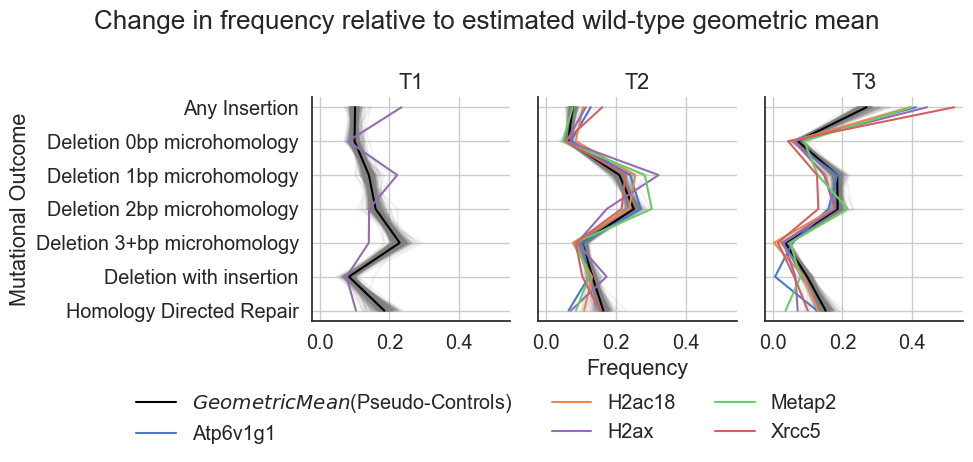

In [7]:
genes = top5

def control_comparison_plot(X_plot, pseudo_controls=[], \
                            compare_genes = [], background_genes = None, ax=None, palette=None):
    columns = X_plot.columns
    X_plot = X_plot.div(X_plot.sum(axis=1), axis=0)
    X_plot = X_plot.groupby(["Gene"]).mean()
    X_plot = pd.DataFrame(X_plot.values.tolist(), index=X_plot.index, columns=columns)
    X_plot.columns = X_plot.columns.to_list()


    linepdata = X_plot.loc[background_genes if background_genes is not None else pseudo_controls, :].T
    linepdata.index.name = "Feature"
    outcome_order = list(linepdata.index.sort_values())

    for col in linepdata.columns:
        p = linepdata.loc[outcome_order[::-1], col].reset_index()
        y = p.index
        x = p[col]
        labels = p["Feature"]
        ax.plot(x, y, color="grey", alpha=0.1)

    if pseudo_controls is not None:
        psudeo_control_profile = X_plot.loc[pseudo_controls, :]
        psudeo_control_avg_profile = psudeo_control_profile.mean()
        logfolddf = np.log2(X_plot/psudeo_control_avg_profile)
        logfolddf.head()
        ax.plot(linepdata.loc[outcome_order[::-1],:].mean(axis=1), y, color="black", label="$Geometric Mean$(Pseudo-Controls)")

    for gene in compare_genes:
        p = X_plot.T.loc[outcome_order[::-1], gene].reset_index()
        y = p.index
        x = p[gene]
        labels = p["Feature"]
        ax.plot(x, y, label=gene, color=palette[gene] if palette is not None else None)

    ax.set_yticks(y, labels)
    ax.grid()

    return None

def assign_colors(genes):
    colors = {}
    for i, g in enumerate(genes):
        colors[g] = sns.color_palette()[i]
    return colors

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
for i, sample in enumerate(X_imputed.keys()):
    control_comparison_plot(
        df.loc[sample].dropna(axis=1), 
        pseudo_controls=psuedo_controls,
        background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(genes, df.loc[sample].dropna(axis=1).index.to_list()),
        ax = ax[i], palette=assign_colors(genes))
    ax[i].set_title(sample)

handles, labels = ax[i].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15), frameon=False)
ax[1].set_xlabel("Frequency")
ax[0].set_ylabel("Mutational Outcome")
mysuptitle = plt.suptitle("Change in frequency relative to estimated wild-type geometric mean")
plt.tight_layout()
plt.savefig("artifacts/top5genes.pdf", bbox_extra_artists=(lgd, mysuptitle), bbox_inches='tight')

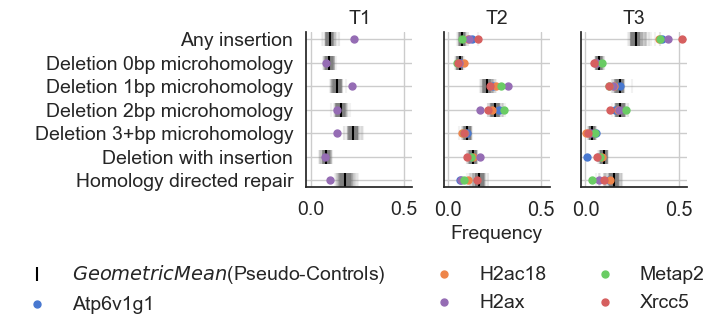

In [8]:
genes = top5
df.columns = df.columns.str.capitalize()

def control_comparison_plot(X_plot, pseudo_controls=[], \
                            compare_genes = [], background_genes = None, ax=None, palette=None):
    columns = X_plot.columns
    X_plot = X_plot.div(X_plot.sum(axis=1), axis=0)
    X_plot = X_plot.groupby(["Gene"]).mean()
    X_plot = pd.DataFrame(X_plot.values.tolist(), index=X_plot.index, columns=columns)
    X_plot.columns = X_plot.columns.to_list()


    linepdata = X_plot.loc[background_genes if background_genes is not None else pseudo_controls, :].T
    linepdata.index.name = "Feature"
    outcome_order = list(linepdata.index.sort_values())

    for col in linepdata.columns:
        p = linepdata.loc[outcome_order[::-1], col].reset_index()
        y = p.index
        x = p[col]
        labels = p["Feature"]
        ax.scatter(x, y, color="grey", alpha=0.1, marker="|", s=100)

    if pseudo_controls is not None:
        psudeo_control_profile = X_plot.loc[pseudo_controls, :]
        psudeo_control_avg_profile = psudeo_control_profile.mean()
        logfolddf = np.log2(X_plot/psudeo_control_avg_profile)
        logfolddf.head()
        ax.scatter(linepdata.loc[outcome_order[::-1],:].mean(axis=1), y, color="black", label="$Geometric Mean$(Pseudo-Controls)", marker="|", s=100)

    for gene in compare_genes:
        p = X_plot.T.loc[outcome_order[::-1], gene].reset_index()
        y = p.index
        x = p[gene]
        labels = p["Feature"]
        ax.scatter(x, y, label=gene, color=palette[gene] if palette is not None else None, marker=".", s=100)

    ax.set_yticks(y, labels, fontsize=12)
    ax.grid()

    return None

def assign_colors(genes):
    colors = {}
    for i, g in enumerate(genes):
        colors[g] = sns.color_palette()[i]
    return colors

fig, ax = plt.subplots(1, 3, figsize=(7, 2.8), sharey=True, sharex=True)
for i, sample in enumerate(X_imputed.keys()):
    control_comparison_plot(
        df.loc[sample].dropna(axis=1), 
        pseudo_controls=psuedo_controls,
        background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(genes, df.loc[sample].dropna(axis=1).index.to_list()),
        ax = ax[i], palette=assign_colors(genes))
    ax[i].set_title(sample, fontsize=14)

handles, labels = ax[i].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.23), frameon=False, fontsize=14)
ax[1].set_xlabel("Frequency", fontsize=14)
ax[0].set_ylabel(None)
ax[0].tick_params(axis='both', which='major', labelsize=14)

# mysuptitle = plt.suptitle("Mutational spectra of top 5 scoring genes", fontsize=16)
plt.tight_layout()
plt.savefig("artifacts/top5genes.pdf", bbox_extra_artists=[lgd], bbox_inches='tight')

In [9]:
ax[0].get_yticklabels()

[Text(0, 0, 'Homology directed repair'),
 Text(0, 1, 'Deletion with insertion'),
 Text(0, 2, 'Deletion 3+bp microhomology'),
 Text(0, 3, 'Deletion 2bp microhomology'),
 Text(0, 4, 'Deletion 1bp microhomology'),
 Text(0, 5, 'Deletion 0bp microhomology'),
 Text(0, 6, 'Any insertion')]

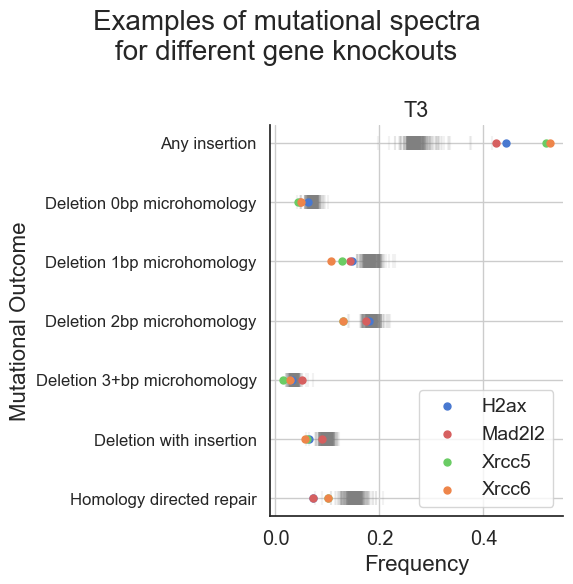

In [10]:
genes = ["H2ax", "Xrcc6", "Xrcc5", "Mad2l2"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True, sharex=True)
sample = "T3"
control_comparison_plot(
    df.loc[sample].dropna(axis=1), 
    pseudo_controls=None,
    background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
    compare_genes = np.intersect1d(genes, df.loc[sample].dropna(axis=1).index.to_list()),
    ax = ax, palette=assign_colors(genes))
ax.set_title(sample)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, fontsize=14)
ax.set_xlabel("Frequency", fontsize=16)
ax.set_ylabel("Mutational Outcome", fontsize=16)
plt.suptitle("Examples of mutational spectra\nfor different gene knockouts", fontsize=20)
plt.tight_layout()
plt.savefig("artifacts/fig_1_biosb.pdf")
plt.savefig("artifacts/fig_1_biosb.png")

566

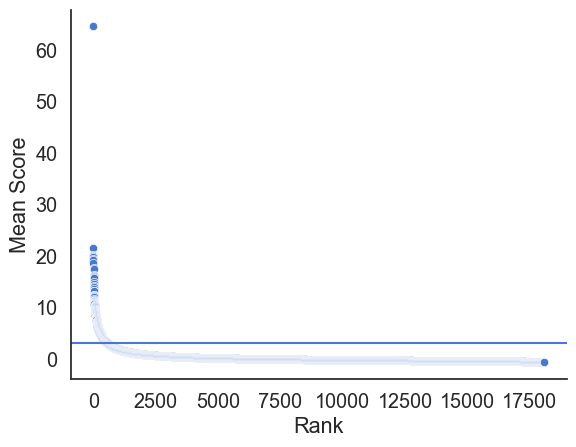

In [11]:
scatter_df = outlier_details_df["Global"]["Mean Score"].sort_values()[::-1].to_frame()
scatter_df["Rank"] = scatter_df["Mean Score"].rank(ascending=False)

sns.scatterplot(data=scatter_df, x="Rank", y="Mean Score")

limit=3
plt.axhline(3)

sum(scatter_df["Mean Score"] > 3)